# Sentiment Analysis using twitter data

Simple Deep Neural Network, that predicts tweet sentiment. The model can be greatly improved using various <br/>
word vectorization techniques and Recurrent Neural Networks.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import tflearn as tflearn
from nltk.corpus import stopwords
import preprocessor as p
import re
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

In [2]:

test_path = "./data/twitter_test.txt"
training_path = "./data/twitter_data.txt"

def all_stop_words():
    stop_words = stopwords.words('english')
    add_stopwords = [",", "*" , ")" , "(" ,".","theres","know","one","though","vinci","ive","da","book","im","went",
                    "potter","brokeback","mountain","harry","code","mission","impossible","movie","movies","i","ya",
                    "yet","yall"]
    for w in add_stopwords:
        stop_words.append(w)
    return stop_words


stop_words = all_stop_words()
def training_data_df(path):
    
    training_data = open(path,mode='r')
    training_array =[]
    for d in training_data:
        training_dict = {}
        sent_tweet_array = d.split('\t')
        training_dict['tweet'] = sent_tweet_array[1].lower()
        training_dict['cleaned_tweet'] =remove_stop_words(sent_tweet_array[1].lower())
        training_dict['positive'] =int(sent_tweet_array[0])
        training_array.append(training_dict)
    training_df = pd.DataFrame(training_array)
    return training_df

def sentiment(sentiment_prob):
    if sentiment_prob[0]>sentiment_prob[1]:
        return "positive"
    return "negative"

def remove_stop_words(tweet_text):
    tweet_text = re.sub(r'[?|$|.|!]',r'',tweet_text)
    tweet_text = re.sub(r'[^a-zA-Z0-9 ]',r'',tweet_text)
    result = ""
    for word in tweet_text.split():            
        if word not in stop_words:
            result = result +" "+word.lower()

    return result.lstrip()

def get_word_frequency(tweet_list):
    word_dict = {} 
    result_array=[]
    for tw in tweet_list:
        for word in tw.split():
            if word in word_dict.keys():
                word_dict[word] = word_dict[word]+1
                continue
            word_dict[word] = 1
    for k in word_dict.keys():
        result_array.append({'word':k, 'count':word_dict[k]})
    return pd.DataFrame(result_array,columns=['count','word'])


def common_pos_words(df_data):
    return common_words_filter(df_data,1)

def common_neg_words(df_data):
    return common_words_filter(df_data,0)

def common_words_filter(df_data,sent):
    pos_tweet =df_data[df_data["positive"] ==sent]
    all_tweets = pos_tweet["tweet"].str.cat(sep='|')
    common_words=[]
    for pos_tw in pos_tweet["tweet"]:
        for tw in all_tweets.split('|'):
            if pos_tw == tw:
                continue
            tw_list = list(tw.split())
            pos_list = list(pos_tw.split())
            inter = list(set(tw_list).intersection(pos_list))
            for word in inter:
                if word not in common_words:
                    common_words.append(word)
    return common_words

In [3]:
training_data = training_data_df(training_path)
# test_data = training_data_df(test_path)
training_data["neg"] = training_data["positive"].apply(lambda x: 0 if x==1 else 1)
vect = CountVectorizer(stop_words=all_stop_words())
print("All data:",training_data.shape[0])
# print("Test data:",test_data.shape[0])

All data: 7087


In [35]:
LOG_DIR = "/tmp/tflearn_logs/basic_senti"
with open (LOG_DIR+'/metadata.tsv','w') as mappings:
    words = []
    for sent in training_data["cleaned_tweet"]:
        mappings.write("{}\n".format(sent))
        for word in sent.split():            
            if word in words:
                continue
            mappings.write("{}\n".format(word))
            words.append(word)


In [4]:
training_data

,cleaned_tweet,positive,tweet,neg
0,feeel like aaa reetard,0,i feeel like aaa reetard\n,1
1,awesome,1,the da vinci code book is just awesome.\n,0
2,first clive cussler ever read even books like ...,1,this was the first clive cussler i've ever rea...,0
3,liked lot,1,i liked the da vinci code a lot.\n,0
4,liked lot,1,i liked the da vinci code a lot.\n,0
5,liked ultimatly didnt seem hold,1,i liked the da vinci code but it ultimatly did...,0
6,thats even exaggeration midnight walmart buy a...,1,that's not even an exaggeration ) and at midni...,0
7,loved want something better different,1,"i loved the da vinci code, but now i want some...",0
8,thought great kite runner,1,"i thought da vinci code was great, same with k...",0
9,actually good,1,the da vinci code is actually a good movie...\n,0


In [5]:
training_data = training_data[['positive','neg','cleaned_tweet', 'tweet']]
training_data.values

array([[0, 1, 'feeel like aaa reetard', 'i feeel like aaa reetard\n'],
       [1, 0, 'awesome', 'the da vinci code book is just awesome.\n'],
       [1, 0,
        'first clive cussler ever read even books like relic plausible',
        "this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.\n"],
       ..., 
       [0, 1, 'sit watching mtv awards reminded much despised',
        'as i sit here, watching the mtv movie awards, i am reminded of how much i despised the movie brokeback mountain.\n'],
       [0, 1, 'ok horrible',
        'ok brokeback mountain is such a horrible movie.\n'],
       [0, 1, 'oh terrible',
        'oh, and brokeback mountain was a terrible movie.\n']], dtype=object)

### One-hot Encode

In [8]:
vect.fit(training_data["cleaned_tweet"])
word_matrix = vect.transform(training_data["cleaned_tweet"]).toarray()
print(word_matrix.shape)

(7087, 2072)


In [9]:
num_features = word_matrix.shape[1]
print("Total features: ",num_features)
classes = training_data.values[:,:2]

Total features:  2072


In [10]:
trX,testX,trY,testY = train_test_split(word_matrix,classes)   
print("Training data:",trX.shape[0])
print("Test data:",testX.shape[0])

Training data: 5315
Test data: 1772


In [11]:
print(vect.inverse_transform(testX))


[array(['love'], 
      dtype='<U62'), array(['begin', 'better', 'hate', 'material', 'much', 'outshines', 'plain',
       'reading', 'stupid', 'think'], 
      dtype='<U62'), array(['community', 'friends', 'good', 'joining', 'like', 'make', 'really',
       'start', 'things', 'thought', 'would'], 
      dtype='<U62'), array(['awesome', 'mocking'], 
      dtype='<U62'), array(['anyway', 'love', 'thats'], 
      dtype='<U62'), array(['love'], 
      dtype='<U62'), array(['awesome'], 
      dtype='<U62'), array(['bitch', 'coz', 'goin', 'hella', 'hill', 'like', 'reality', 'said',
       'silent', 'turned'], 
      dtype='<U62'), array(['always', 'crazy', 'guy', 'hates', 'knows', 'want'], 
      dtype='<U62'), array(['sucks'], 
      dtype='<U62'), array(['great', 'night', 'sucked'], 
      dtype='<U62'), array(['like', 'never', 'right', 'side', 'whos'], 
      dtype='<U62'), array(['desperately', 'film', 'lovethe', 'wanted'], 
      dtype='<U62'), array(['awesome'], 
      dtype='<U62'), a

In [10]:
print(vect.inverse_transform(trX))

[array(['idk', 'looked', 'stupid'], 
      dtype='<U62'), array(['love'], 
      dtype='<U62'), array(['absurd', 'lot', 'loved', 'questions', 'raises', 'theological'], 
      dtype='<U62'), array(['lol', 'sucked'], 
      dtype='<U62'), array(['desperately', 'film', 'lovethe', 'wanted'], 
      dtype='<U62'), array(['anyone', 'care', 'dont', 'says', 'shitty'], 
      dtype='<U62'), array(['love'], 
      dtype='<U62'), array(['25', 'heard', 'much', 'soo', 'stars', 'sucked'], 
      dtype='<U62'), array(['horrible', 'looks', 'three'], 
      dtype='<U62'), array(['beautiful'], 
      dtype='<U62'), array(['anyone', 'awesome', 'care', 'differently', 'dont', 'says'], 
      dtype='<U62'), array(['friday', 'hung', 'kelsie', 'saw', 'sucked'], 
      dtype='<U62'), array(['sucked'], 
      dtype='<U62'), array(['escapades', 'kate', 'kirsten', 'leah', 'love', 'tom', 'well'], 
      dtype='<U62'), array(['awesome', 'last', 'stand'], 
      dtype='<U62'), array(['betterwe', 'bogus', 'inaccurate

# Deep Neural Network


Consists of : 
<ul>
<li>Input layer </li> 
<li>Hidden layer with 300 neurons</li> 
<li>Output softmax layer, which outputs the likelyhood of a class: [1,0]</li>
</ul>

<img src="./data/nn-architecture.png"/>

In [46]:
from tensorflow.contrib.tensorboard.plugins import projector
import os

LOG_DIR = "/tmp/tflearn_logs/basic_senti"
tf.reset_default_graph()
graph = tf.get_default_graph()
sess = tf.Session(graph=graph)
# sess = tf.Session()
input_data = tflearn.input_data(shape=[None, num_features],)
init_weights = tflearn.initializations.truncated_normal(shape=None,dtype=tf.float32, seed=None)
layer1 = tflearn.layers.fully_connected(input_data,300,activation='sigmoid',weights_init=init_weights,regularizer='L2')
dropout = tflearn.dropout(layer1,keep_prob=0.65)

net  =tflearn.layers.fully_connected(dropout , 2,activation='softmax',regularizer='L2')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
model = tflearn.DNN(net,tensorboard_verbose=3,session=sess,tensorboard_dir=LOG_DIR,
                    checkpoint_path=LOG_DIR +'/model.ckpt')
init_op = tf.global_variables_initializer()



config = projector.ProjectorConfig()
# You can add multiple embeddings. Here we add only one.
viz_emd = config.embeddings.add()
viz_emd.tensor_name = input_data.name
# Link this tensor to its metadata file (e.g. labels).
viz_emd.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR,graph)
# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, config)


sess.run(init_op)

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'


In [47]:
model.fit(trX,trY,n_epoch=5,show_metric=True,validation_set=.2)
evl = model.evaluate(testX,testY,)
print("Evaluation: ",evl)

Training Step: 334  | total loss: 0.16414 | time: 5.704s
| Adam | epoch: 005 | loss: 0.16414 - acc: 0.9698 -- iter: 4224/4252
Training Step: 335  | total loss: 0.16671 | time: 6.792s
| Adam | epoch: 005 | loss: 0.16671 - acc: 0.9712 | val_loss: 0.12449 - val_acc: 0.9802 -- iter: 4252/4252
--
INFO:tensorflow:/tmp/tflearn_logs/basic_senti/model.ckpt-335 is not in all_model_checkpoint_paths. Manually adding it.
Evaluation:  [0.98984198712872062]


             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99       770
        1.0       0.99      0.99      0.99      1002

avg / total       0.99      0.99      0.99      1772

[[758  12]
 [  6 996]]
AUC = 0.9892


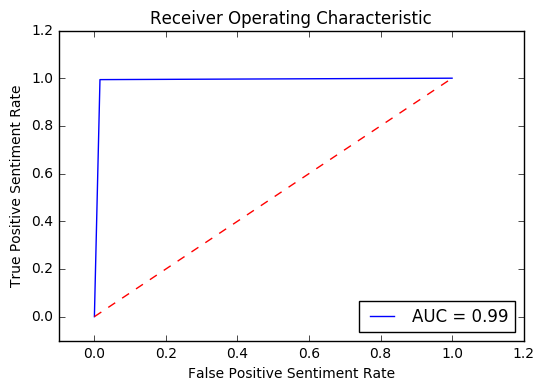

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt

def auc_curve():
    test_y=testY[:,0]
    pred = []
    i=0
    for t in testX:
        p = model.predict([t])
        p_toarray = np.asarray(p)[0]
        if p_toarray[0]>p_toarray[1]:
            pred.append(1.0)
        else:
            pred.append(0.0)
    print(metrics.classification_report(test_y.astype(float), np.asarray(pred)))
    print(metrics.confusion_matrix(test_y.astype(float), pred))
    fpr, tpr, thresholds = metrics.roc_curve(test_y, np.asarray(pred))
    roc_auc = auc(fpr, tpr)
    print('AUC = %0.4f'% roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Sentiment Rate')
    plt.xlabel('False Positive Sentiment Rate')
    plt.show()
    

auc_curve()

# Inspecting training data

### Positive sentiment

In [49]:
for t in training_data[training_data["positive"] ==1]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: the da vinci code book is just awesome.

[ 0.93103051  0.06896951]
sentiment: positive
--------
Tweet: this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.

[ 0.91008633  0.08991364]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.74353158  0.25646842]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.74353158  0.25646842]
sentiment: positive
--------
Tweet: i liked the da vinci code but it ultimatly didn't seem to hold it's own.

[ 0.74425882  0.25574121]
sentiment: positive
--------
Tweet: that's not even an exaggeration ) and at midnight we went to wal-mart to buy the da vinci code, which is amazing of course.

[ 0.56532204  0.43467796]
sentiment: positive
--------
Tweet: i loved the da vinci code, but now i want something better and different!..

[ 0.85744023  0.14255977]
sentiment: positive
--------
Tweet: i thought da vinci code was great, same with kit

### Negative sentiment

In [50]:

for t in training_data[training_data["positive"] ==0]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: i feeel like aaa reetard

[ 0.82763803  0.172362  ]
sentiment: positive
--------
Tweet: da vinci code was a terrible movie.

[ 0.25139016  0.74860984]
sentiment: negative
--------
Tweet: then again, the da vinci code is super shitty movie, and it made like 700 million.

[ 0.80627155  0.19372846]
sentiment: positive
--------
Tweet: the da vinci code comes out tomorrow, which sucks.

[ 0.12464888  0.87535113]
sentiment: negative
--------
Tweet: i thought the da vinci code movie was really boring.

[ 0.15801863  0.84198135]
sentiment: negative
--------
Tweet: god, yahoo games has this truly-awful looking da vinci code-themed skin on it's chessboard right now.

[ 0.42745838  0.57254165]
sentiment: negative
--------
Tweet: da vinci code does suck.

[ 0.19410786  0.80589217]
sentiment: negative
--------
Tweet: and better...-we all know da vinci code is bogus and inaccurate.

[ 0.4744629   0.52553713]
sentiment: negative
--------
Tweet: last time, da vinci code is also a bit disappoint

### Custom data

In [51]:
# testing_file = open(test_path,mode='r')
# testing_tweets=[]
# for x in testing_file:
#     s= remove_stop_words(x)
#     testing_tweets.append(s)
# testing_tweets=["It’s likely something has gone wrong with the product or experience you’re reviewing that isn’t \
# representative of what the company offers 99.9 per cent of the time", 
#                 "If you think they have a point, you’re probably best taking it down immediately",
#                "I was surprised that the material was a rough burlap instead of the linen listed in the ad. I do \
#                 still like \
#                 the way it looks as it's decorative so feel isn't that important to me anyways."]

testing_tweets=["Besides the tasty food, the service is incredible!",
                "Horrible service. Absolutely no sense of customer service and how to take an order. \
                Your order will never reach you.","Good food but very slow service, no matter what time of day you come. Even if you order over phone still prepare to wait at least 30 mnts or more."]

for t in testing_tweets:
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: Besides the tasty food, the service is incredible!
[ 0.51561981  0.48438025]
sentiment: positive
--------
Tweet: Horrible service. Absolutely no sense of customer service and how to take an order.                 Your order will never reach you.
[ 0.39915603  0.60084403]
sentiment: negative
--------
Tweet: Good food but very slow service, no matter what time of day you come. Even if you order over phone still prepare to wait at least 30 mnts or more.
[ 0.58494717  0.41505286]
sentiment: positive
--------


In [206]:
print(vect.transform(["satisfied"]))